# Import Libraries/Packages

In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt 

from keras.models import Sequential  
from keras.callbacks import EarlyStopping
from keras.backend import clear_session

from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras import utils
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

# Load Dataset

In [2]:
data_train_temp = np.load('kmnist-train-imgs.npz')
labels_train_temp = np.load('kmnist-train-labels.npz')
data_test_temp = np.load('kmnist-test-imgs.npz')
labels_test_temp = np.load('kmnist-test-labels.npz')

In [3]:
data_train = data_train_temp['arr_0']
labels_train = labels_train_temp['arr_0']
data_test = data_test_temp['arr_0']
labels_test = labels_test_temp['arr_0']

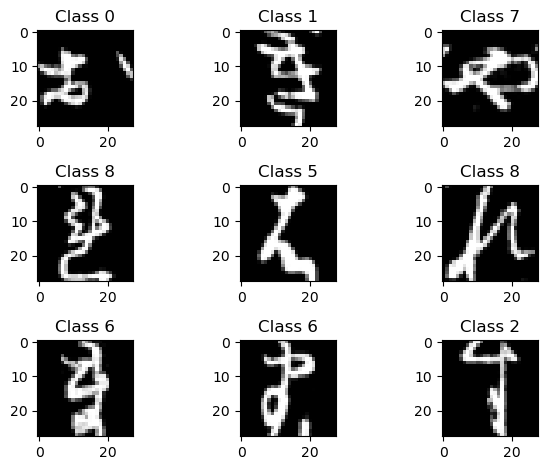

In [4]:
for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(data_train))
    plt.imshow(data_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(labels_train[num]))
    
plt.tight_layout()

In [5]:
data_train = data_train.reshape(60000, 784) 
data_test = data_test.reshape(10000, 784)   

data_train = data_train.astype('float32')   
data_test = data_test.astype('float32')

#data_train /= 255                        
#data_test /= 255

#data_train = data_train.reshape((data_train.shape[0], 28, 28, 1))
#data_test = data_test.reshape((data_test.shape[0], 28, 28, 1))

print("Training matrix shape", data_train.shape)
print("Testing matrix shape", data_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


# Part 1: Design an SAE

In [6]:
#bottle_neck = 10
#in_shape = 784
#clear_session()

In [7]:
def build_enc(in_shape, bottle_neck, act1, act2, act3):
    enc_model = Sequential()
    enc_model.add(Dense(784, activation=act1, input_shape=(in_shape,)))
    enc_model.add(Dense(200, activation=act2))
    enc_model.add(Dense(bottle_neck, activation=act3))
    return enc_model

In [8]:
def build_dec(bottle_neck, act1, act2, act3):
    dec_model = Sequential()
    dec_model.add(Dense(bottle_neck, activation=act1, input_shape=(bottle_neck,)))
    dec_model.add(Dense(200, activation=act2))
    dec_model.add(Dense(784, activation=act3))
    return dec_model

In [9]:
def build_sae(in_shape, bottle_neck, act1, act2, act3, act4, act5, act6):
    enc_model = build_enc(in_shape, bottle_neck, act1, act2, act3)
    dec_model = build_dec(bottle_neck, act4, act5, act6)
    
    sae_model = Sequential()
    sae_model.add(enc_model)
    sae_model.add(dec_model)
    
    return sae_model

In [31]:
clear_session()

IN_SHAPE = 784
bottle_neck = [50,60]

sae_models = []
adam = Adam(learning_rate=0.001)

for bn in bottle_neck:
    sae_models.append(build_sae(IN_SHAPE, bn, 'relu', 'relu', 'relu', 'relu', 'relu', 'relu'))
    sae_models[-1].compile(optimizer=adam, loss='mean_squared_error')

In [32]:
callback = EarlyStopping(monitor='loss', patience=2, min_delta=1)
sae_models[0].fit(data_train, data_train,
                 batch_size=128, epochs=50,
                 verbose=1, callbacks=[callback])

Epoch 1/50
469/469 [==============================] - 7s 12ms/step - loss: 4264.0532
Epoch 2/50
469/469 [==============================] - 5s 12ms/step - loss: 3111.5134
Epoch 3/50
469/469 [==============================] - 5s 11ms/step - loss: 2870.3555
Epoch 4/50
469/469 [==============================] - 5s 11ms/step - loss: 2776.0718
Epoch 5/50
469/469 [==============================] - 6s 13ms/step - loss: 2689.3247
Epoch 6/50
469/469 [==============================] - 6s 13ms/step - loss: 2624.9255
Epoch 7/50
469/469 [==============================] - 6s 13ms/step - loss: 2588.3652
Epoch 8/50
469/469 [==============================] - 6s 13ms/step - loss: 2553.2988
Epoch 9/50
469/469 [==============================] - 6s 14ms/step - loss: 2512.7695
Epoch 10/50
469/469 [==============================] - 6s 13ms/step - loss: 2490.4380
Epoch 11/50
469/469 [==============================] - 6s 14ms/step - loss: 2476.9451
Epoch 12/50
469/469 [==============================] - 6s 13ms/

In [33]:
y_pred = sae_models[0].predict(data_test[0:5])

1/1 [==============================] - 0s 175ms/step


In [37]:
show = y_pred[0]

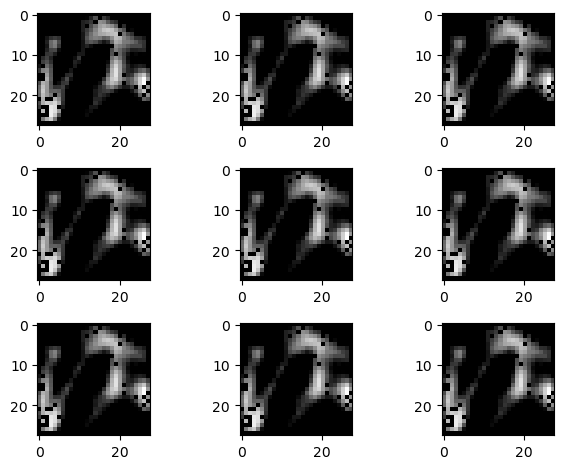

In [39]:
for i in range(9):
    plt.subplot(3,3,i+1)
    #num = random.randint(0, len(data_train))
    plt.imshow(show.reshape((28,28)), cmap='gray', interpolation='none')
    #plt.title("Class {}".format(labels_train[num]))
    
plt.tight_layout()